# %%[markdown]

 Author: Nelson Liu

 Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# %%[markdown]

 # Plot FUNMAN Results

 Request:
 ```
 request: dict
     query: None
     label: str
     constraints: list[dict]
     parameters: list[dict]
         name: str
         interval: dict
             lb: float
             ub: float
             closed_upper_bound: bool
             original_width: float
             normalized: bool
             unnormalized_lb: None
             unnormalized_ub: None
     config: dict
         tolerance: float <===
         normalization_constant: 1.0 # <===
         use_compartmental_constraints: True # <===
         queue_timeout: int
         number_of_processes: 1
         wait_timeout: None,
         wait_action_timeout: 0.05
         solver: 'dreal'
         num_steps: 2
         step_size: 1
         num_initial_boxes: 1
         initial_state_tolerance: 0.0
         save_smtlib: None
         dreal_precision: 0.1
         dreal_log_level: 'off'
         constraint_noise: 0.0
         dreal_mcts: True
         substitute_subformulas: False
         normalize: True
         simplify_query: False
         series_approximation_threshold: None
         profile: False
         taylor_series_order: None
         corner_points: False
         verbosity: 20
         use_transition_symbols: False
     structure_parameters: list[dict]
         name: 'schedules' # <===
         schedules: list[dict] <===
             timepoints: list
         label : str
         interval: dict
             lb: float
             ub: float
             closed_upper_bound: bool
             original_width: None
             normalized_width: False
             unnormalized_lb: None
             unnormalized_ub: None
 ```

 Result:
 ```
 result: dict
     id: str
     model: dict
     progress: dict
         progress: float
         coverage_of_search_space: float
         coverage_of_representable_space: float
     done: bool
     error: bool
     error_message: str
     parameter_space: dict
         number_dimensions: int
         true_boxes: list[dict]
             type: 'box'
             label: 'true'
             bounds: dict
                 <parameter>: dict
                     lb: float
                     ub: float
                     closed_upper_bound: bool
                     original_width: float
                     normalized: bool
                     unnormalized_lb: float
                     unnormalized_ub: float
             explanation: dict
                 relevant_assumptions: list
                 expression: str
             schedule: dict
                 timepoints: list
             corner_points: list[dict]
             points: list[dict]
                 type: 'point'
                 label: 'true'
                 value: dict
                     <parameter>: float
                     <variable>_*: float
                     solver_step_*: float
                 normalized_values: dict
                 schedule: dict
                     timepoints: list
         false_boxes: list[dict]
         unknown_points: list[dict]
 ```

In [ ]:
# %%

import os
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import sympy
import pandas
from mira.metamodel import *
from mira.modeling.viz import GraphicalModel
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json

In [ ]:
# %%

# Load Funman output
# p = "../data/example0/result.json"
p = "../result.json"
with open(p, "r") as f:
    result = json.load(f)

In [ ]:
# %%

def generate_dfs(result: dict) -> pandas.DataFrame:

    for k in ("true_boxes", "false_boxes", "unknown_points"):
        print(f"Number of {k} = {len(result["parameter_space"][k])}")

    # Time points
    timepoints = result["request"]["structure_parameters"][0]["schedules"][0]["timepoints"]
    states = [s["id"] for s in result["model"]["petrinet"]["model"]["states"]]

    # Boxes
    id = 0
    data_boxes = {"id": [], "type": [], "label": [], "num_points": [], "num_corner_points": [], "timestep_lb": [], "timestep_ub": []}
    for k in ("true", "false"):
        for box in result["parameter_space"][f"{k}_boxes"]:
            
            data_boxes["id"].append(id)
            id += 1

            data_boxes["type"].append(box["type"])
            data_boxes["label"].append(box["label"] == "true")
            data_boxes["num_points"].append(len(box["points"]))
            data_boxes["num_corner_points"].append(len(box["corner_points"]))
            data_boxes["timestep_lb"].append(box["bounds"]["timestep"]["lb"])
            data_boxes["timestep_ub"].append(box["bounds"]["timestep"]["ub"])

    # Upper, lower bounds
    parameters = [p["id"] for p in result["model"]["petrinet"]["semantics"]["ode"]["parameters"]]
    id = 0
    data_bounds_lb = {"box_id": []} | {p: [] for p in parameters}
    data_bounds_ub = {"box_id": []} | {p: [] for p in parameters}
    for k in ("true", "false"):
        for box in result["parameter_space"][f"{k}_boxes"]:
            
            data_bounds_lb["box_id"].append(id)
            data_bounds_ub["box_id"].append(id)
            id += 1

            for p in parameters:
                data_bounds_lb[p].append(box["bounds"][p]["lb"])
                data_bounds_ub[p].append(box["bounds"][p]["ub"])
    
    # Points
    box_id = 0
    id = 0
    data_points = {"box_id": [], "id": [], "label": []} | {p: [] for p in parameters}
    data_traj = {}
    for k in ("true", "false"):
        for box in result["parameter_space"][f"{k}_boxes"]:

            data = {}
            for point in box["points"]:

                data_points["box_id"].append(box_id)
                

                data_points["id"].append(id)
                data_points["label"].append(point["label"])

                for p in parameters:
                    data_points[p].append(point["values"][p])

                data = {"timepoints": [t for t in timepoints if f"{states[0]}_{t}" in point["values"].keys()]} | {
                    state: [point["values"][f"{state}_{t}"] for t in timepoints if f"{state}_{t}" in point["values"].keys()]
                    for state in states
                }
                
                # Trajectories
                data_traj[id] = data

                id += 1
            
            box_id += 1

    
    # Corner points
    # data_corner_points = {}

    # Unknown points
    id = 0
    data_unknown_points = {"id": [], "label": []} | {p: [] for p in parameters}
    data_unknown_traj = {}
    for point in result["parameter_space"]["unknown_points"]:
        data_unknown_points["id"].append(id)
        data_unknown_points["label"].append(point["label"])
        for p in parameters:
            data_unknown_points[p].append(point["values"][p])

        data = {"timepoints": [t for t in timepoints if f"{states[0]}_{t}" in point["values"].keys()]} | {
            state: [point["values"][f"{state}_{t}"] for t in timepoints if f"{state}_{t}" in point["values"].keys()]
            for state in states
        }
        data_unknown_traj[id] = data

        id += 1


    df_boxes = pandas.DataFrame(data_boxes)
    df_bounds_lb = pandas.DataFrame(data_bounds_lb)
    df_bounds_ub = pandas.DataFrame(data_bounds_ub)
    df_points = pandas.DataFrame(data_points)
    df_unknown_points = pandas.DataFrame(data_unknown_points)


    return df_boxes, df_bounds_lb, df_bounds_ub, df_points, data_traj, df_unknown_points, data_unknown_traj


df_boxes, df_bounds_lb, df_bounds_ub, df_points, data_traj, df_unknown_points, data_unknown_traj = generate_dfs(result)

Number of true_boxes = 584
Number of false_boxes = 62
Number of unknown_points = 495


In [ ]:
# %%

df_boxes

,id,type,label,num_points,num_corner_points,timestep_lb,timestep_ub
0,0,box,True,1,0,7.0,7.0
1,1,box,True,1,0,8.0,8.0
2,2,box,True,1,0,9.0,9.0
3,3,box,True,1,0,10.0,10.0
4,4,box,True,1,0,7.0,7.0
...,...,...,...,...,...,...,...
641,641,box,False,1,0,1.0,10.0
642,642,box,False,0,0,3.0,10.0
643,643,box,False,1,0,2.0,10.0
644,644,box,False,1,0,2.0,10.0


In [ ]:
# %%

df_bounds_lb

,box_id,beta,gamma,S0,I0,R0
0,0,0.010000,0.022976,0.99,0.01,0.0
1,1,0.010000,0.022976,0.99,0.01,0.0
2,2,0.010000,0.022976,0.99,0.01,0.0
3,3,0.010000,0.022976,0.99,0.01,0.0
4,4,0.010000,0.034396,0.99,0.01,0.0
...,...,...,...,...,...,...
641,641,0.952716,0.010000,0.99,0.01,0.0
642,642,0.953913,0.751043,0.99,0.01,0.0
643,643,0.976013,0.675428,0.99,0.01,0.0
644,644,0.968032,0.655705,0.99,0.01,0.0


In [ ]:
# %%

df_bounds_ub

,box_id,beta,gamma,S0,I0,R0
0,0,0.034067,0.034396,0.99,0.01,0.0
1,1,0.034067,0.034396,0.99,0.01,0.0
2,2,0.034067,0.034396,0.99,0.01,0.0
3,3,0.034067,0.034396,0.99,0.01,0.0
4,4,0.036732,0.042083,0.99,0.01,0.0
...,...,...,...,...,...,...
641,641,0.973028,0.040268,0.99,0.01,0.0
642,642,0.976001,0.758984,0.99,0.01,0.0
643,643,1.000000,0.696143,0.99,0.01,0.0
644,644,1.000000,0.675428,0.99,0.01,0.0


In [ ]:
# %%

df_points

,box_id,id,label,beta,gamma,S0,I0,R0
0,0,0,true,0.026860,0.028686,0.99,0.01,0.0
1,1,1,true,0.026860,0.028686,0.99,0.01,0.0
2,2,2,true,0.026860,0.028686,0.99,0.01,0.0
3,3,3,true,0.026860,0.028686,0.99,0.01,0.0
4,4,4,true,0.027926,0.038240,0.99,0.01,0.0
...,...,...,...,...,...,...,...,...
646,640,646,false,0.940730,0.660636,0.99,0.01,0.0
647,641,647,false,0.962872,0.023942,0.99,0.01,0.0
648,643,648,false,0.984702,0.690263,0.99,0.01,0.0
649,644,649,false,0.985799,0.665567,0.99,0.01,0.0


646it [00:00, 4003.52it/s]


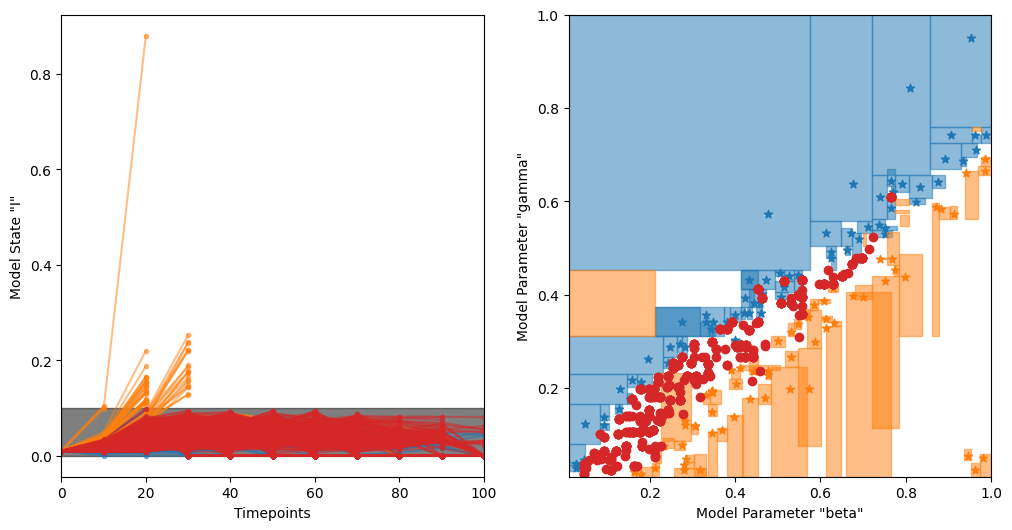

In [ ]:
# %%

# Plot model checks and parameter space

# Timepoint of interest
timepoints  = result["request"]["structure_parameters"][0]["schedules"][0]["timepoints"]
timepoint = timepoints[-1]
timepoint_id = timepoints.index(timepoint)

# Parameters of interest
params = ("beta", "gamma")

colors = mpl.colors.TABLEAU_COLORS
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

ax = axes[0]

# Plot trajectories
state = "I"
__ = plt.setp(ax, xlabel = "Timepoints", ylabel = f"Model State \"{state}\"")

for __, point in df_points.iterrows():

    id = point["id"]
    box_id = point["box_id"]

    if df_boxes.iloc[box_id,:]["timestep_ub"] >= timepoint_id:

        if point["label"] == "true":
            __ = ax.plot(data_traj[id]["timepoints"], data_traj[id][state], marker = ".", color = colors["tab:blue"], alpha = 0.5)
        else:
            __ = ax.plot(data_traj[id]["timepoints"], data_traj[id][state], marker = ".", color = colors["tab:orange"], alpha = 0.5)

for __, point in df_unknown_points.iterrows():

    id = point["id"]
    if point["label"] == "true":
        __ = ax.plot(data_unknown_traj[id]["timepoints"], data_unknown_traj[id][state], marker = ".", color = colors["tab:red"], alpha = 0.5)
    else:
        __ = ax.plot(data_unknown_traj[id]["timepoints"], data_unknown_traj[id][state], marker = ".", color = colors["tab:red"], alpha = 0.5)


# Plot checks
pc = []
for constraint in result["request"]["constraints"]:

    if constraint["variable"] == state:
        x1 = constraint["timepoints"]["lb"]
        x2 = constraint["timepoints"]["ub"]
        y1 = constraint["interval"]["lb"]
        y2 = constraint["interval"]["ub"]

        r = mpl.patches.Rectangle((x1, y1), x2 - x1, y2 - y1, alpha = 0.1)

        pc.append(r)

ax.add_collection(
    mpl.collections.PatchCollection(pc, 
        facecolor = "k", 
        edgecolor = "k",       
        alpha = 1.0 / (len(result["request"]["constraints"]) + 1.0)
    )
)

__ = plt.setp(ax, xlim = (min(timepoints), max(timepoints)))


# Plot boxes
ax = axes[1]

colors = mpl.colors.TABLEAU_COLORS
__ = plt.setp(ax, xlabel = f"Model Parameter \"{params[0]}\"", ylabel = f"Model Parameter \"{params[1]}\"")

pc = {k: [] for k in ("true", "false")}
for i, box in tqdm(df_boxes.iterrows()):

    if box["timestep_ub"] >= timepoint_id:

        box_id = box["id"]

        # Boxes
        x1 = df_bounds_lb[df_bounds_lb["box_id"] == box_id][params[0]]
        x2 = df_bounds_ub[df_bounds_lb["box_id"] == box_id][params[0]]
        y1 = df_bounds_lb[df_bounds_lb["box_id"] == box_id][params[1]]
        y2 = df_bounds_ub[df_bounds_lb["box_id"] == box_id][params[1]]

        r = mpl.patches.Rectangle((x1, y1), x2 - x1, y2 - y1, alpha = 0.1)
        
        if box["label"]:
            pc["true"].append(r)
        else:
            pc["false"].append(r)

        # Points
        points = df_points[df_points["box_id"] == box_id]
        for __, point in points.iterrows():
            x = point[params[0]]
            y = point[params[1]]
            if point["label"] == "true":
                ax.scatter(x, y, marker = "*", color = "tab:blue")
            else:
                ax.scatter(x, y, marker = "*", color = "tab:orange")
    
for k, c in zip(("true", "false"), ("tab:blue", "tab:orange")):
    ax.add_collection(
        mpl.collections.PatchCollection(
            pc[k], 
            facecolor = colors[c],
            edgecolor = colors[c],
            alpha = 0.5,
        )
    )


# Unknown points
for __, point in df_unknown_points.iterrows():
    x = point[params[0]]
    y = point[params[1]]
    if point["label"] == "true":
        ax.scatter(x, y, marker = "o", color = "tab:red")
    else:
        ax.scatter(x, y, marker = "o", color = "tab:red")


# Ranges
for p in result["request"]["parameters"]:
    if p["name"] == params[0]:
        __ = plt.setp(ax, xlim = (p["interval"]["lb"], p["interval"]["ub"]))
    elif p["name"] == params[1]:
        __ = plt.setp(ax, ylim = (p["interval"]["lb"], p["interval"]["ub"]))
    else:
        pass